# Neural style transfer

## Resources 
- [C4W4L06 What is neural style transfer?](https://www.youtube.com/watch?v=R39tWYYKNcI)

## Code Resources 
- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html?highlight=neural%20style
- https://techyhans.com/neural-style-transfer/

## Video
- https://www.youtube.com/watch?v=imX4kSKDY7s

## Paper
- [A Neural Algorithm of Artistic Style, Leon A. Gatys, Alexander S. Ecker, Matthias Bethge](https://arxiv.org/abs/1508.06576)

## Notes

- C is the Content image
- S is the Style image
- G is the Generated image
- Pseudo Plan
    - create a forward pass function or classs to get the C and S activation in layer l
    - initial look into single layer later look into mutiple layer
    - Cost = Content cost and style cost
    - content cost = l2 norm of the activation in layer l 
    $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$
    - style cost = we need gram  matrix

***Before we neural syle transfer we should have clear understanding
about the computation made by the conv layers*** 

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

In [3]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"
# available_device = "cpu"

print(f"{available_device} is available")
device = torch.device(device=available_device)
device

cuda is available


device(type='cuda')

In [4]:
transformImage2Tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transformTensor2Image = transforms.ToPILImage()

In [5]:
def show_tensor(batch, title=None):
    image = batch.cpu().clone()
    image = batch.squeeze(0)
    image = transformTensor2Image(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

    
## To show the activation based on the given tensor grid.
def show_grid_tensor(grid_im, layer_name, n, c=None):
    fig = plt.figure(figsize=(15,15))
    print(layer_name)
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        plt.imshow(grid_im[i], cmap=c)
        plt.axis("off")
        ax.set_title(f"activation {i}")
    return plt

## Loading Content and Style Image
| **Content** | **Style** |
|--- |--- |
| ![](./husky_1.jpg)| ![](./gogh.jpg)



In [192]:
content = Image.open("./content.jpg")
style = Image.open("./pica.jpg")

content_tensor = transformImage2Tensor(content).unsqueeze(0).to(device)
style_tensor = transformImage2Tensor(style).unsqueeze(0).to(device)
# generate_tensor = torch.rand(1,3,224,224) # copy the content rather than creating random

In [193]:
content_tensor.shape

torch.Size([1, 3, 224, 224])

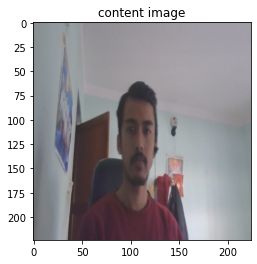

In [194]:
show_tensor(content_tensor, "content image")

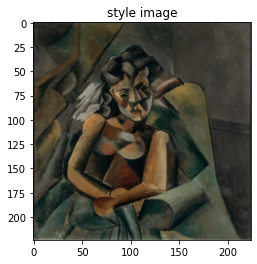

In [195]:
show_tensor(style_tensor, "style image")

## Loading pretrained VGG19 

In [196]:
torch.cuda.empty_cache()

In [197]:
vgg19_model = torchvision.models.vgg19(pretrained=True).to(device)
for parameters in vgg19_model.parameters():
    parameters.requires_grad = False
print(vgg19_model.features)  # we only look only into features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [153]:
features_vgg19 = list(vgg19_model.features)
len(features_vgg19)

37

In [157]:
def forward_vgg19(model, x, layer_to_watch):
    model.eval()
    layer_activation = OrderedDict()
    in_ = x
    for layer_idx, layer in enumerate(features_vgg19):    
        out = layer(in_)
        if layer_idx in layer_to_watch:
            layer_activation[layer_idx]  = out
        in_ = out
#     break
    return layer_activation

In [158]:
style_layer_to_watch = [0, 5, 10, 19, 28]  # layers to get the activation from
content_layer_to_watch = [21]  # layers to get the activation from

layer_to_watch = [0, 5, 10, 19, 28]  # layers to get the activation from


In [116]:
content_activation = forward_vgg19(vgg19_model, content_tensor, layer_to_watch)
content_activation.keys()  # keys refer to the layer activations which haave been recorded

odict_keys([0, 5, 10, 19, 28])

In [117]:
style_activation = forward_vgg19(vgg19_model, style_tensor, style_layer_to_watch)
style_activation.keys() # keys refer to the layer activations which haave been recorded

odict_keys([0, 5, 10, 19, 21, 28])

In [198]:
# generate_activation = forward_vgg19(vgg19_model, generate_tensor, style_layer_to_watch)
# generate_activation.keys() # keys refer to the layer activations which haave been recorded
# # generate_tensor

In [178]:
def compute_content_loss(content_activation, generate_activation, layer_to_watch):
    
     #, torch.float32)
    c_loss = 0.0
    for l in layer_to_watch:
        ca = content_activation[l].detach()
        ga = generate_activation[l]  #.detach()
        el = F.mse_loss(ca , ga)
        c_loss += el
 #     loss = F.mse_loss(content_activation[layer_idx], generate_activation[layer_idx]) # / 2
       
    return c_loss


In [180]:
loss_GC = compute_content_loss(content_activation, generate_activation, layer_to_watch)
loss_GC

tensor(11.8104)

In [181]:
def gram_matrix(in_):
    _, c, h, w = in_.size()
    features = in_.view(c, h * w)  # making Nl and Ml shape feature
    G = torch.mm(features, features.t())
    return G.div(c*h*w) 

def compute_style_loss(style_activation, generate_activation, style_layer_to_watch):
    gram_matrix_style = OrderedDict()
    gram_matrix_generate = OrderedDict()
    s_loss = 0
    for style_l in style_layer_to_watch:
        gram_matrix_style[style_l] = gram_matrix(style_activation[style_l]).detach()
        gram_matrix_generate[style_l] = gram_matrix(generate_activation[style_l]).detach()
        el = F.mse_loss(gram_matrix_style[style_l] , gram_matrix_generate[style_l])
        s_loss += el
    return s_loss

In [106]:
# gram_matrix_out = OrderedDict()
# for style_l in style_activation:
#     gram_matrix_out[style_l] = gram_matrix(style_activation[style_l])
# print(gram_matrix_out[5].shape)

torch.Size([128, 128])


In [183]:
loss_GS = compute_style_loss(style_activation, generate_activation, style_layer_to_watch)
loss_GS

tensor(0.0003)

## Neural Style Transfer

In [135]:
alpha = 0.5
beta =  0.999
alpha/beta

0.5005005005005005

In [185]:
def transfer(generate_tensor, content_tensor, style_tensor , model, style_layer_to_watch, content_layer_to_watch, iteration=30) :

    generate_tensor.requires_grad = True
    alpha = 1
    beta = 0.1

    optimizer = optim.Adam([generate_tensor], lr=0.1, weight_decay=1e-6)
#     loss_GC = loss_GS = torch.tensor(0.0).to(device)
    for i in range(iteration):
        
        loss_GC = loss_GS = torch.tensor(0.0).to(device)
        
        optimizer.zero_grad()
        
        content_activation = forward_vgg19(vgg19_model, content_tensor, content_layer_to_watch)
        style_activation = forward_vgg19(vgg19_model, style_tensor, style_layer_to_watch)
        generate_activation = forward_vgg19(vgg19_model, generate_tensor, style_layer_to_watch)

        loss_GC = compute_content_loss(content_activation, generate_activation, content_layer_to_watch)
        loss_GS = compute_style_loss(style_activation, generate_activation, style_layer_to_watch)
        
        loss = alpha*loss_GC + beta*loss_GS

        if i%100==0:
            print(loss.item())

        loss.backward()

        optimizer.step()

    generate_tensor.requires_grad = False
    return generate_tensor

In [199]:
generate_tensor = content_tensor.clone()
out_image = transfer(generate_tensor, content_tensor, style_tensor, vgg19_model, style_layer_to_watch, layer_to_watch, iteration=2000)

5.401884095590503e-07
1.7467173337936401
1.535194993019104
1.4890347719192505
1.403838872909546
1.3394722938537598
1.3538228273391724
1.334864854812622
1.2631494998931885
1.2356288433074951
1.204193353652954
1.2244354486465454
1.2117103338241577
1.2141185998916626
1.2620183229446411
1.1655693054199219
1.1582317352294922
1.1991779804229736
1.2065849304199219
1.2227072715759277


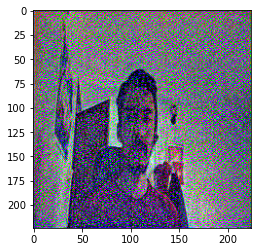

In [200]:
with torch.no_grad():
    plt.imshow(out_image.cpu().squeeze().permute(1,2,0).clamp(max=1, min=0))

In [190]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    
    recreated_im = im_as_var.cpu().data.clone().numpy()[0]
     # done because we we don't want the gradient to be calculated


    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)
#     print(recreated_im.shape)
    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

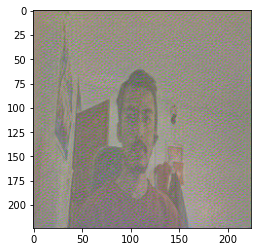

In [191]:
np_image = recreate_image(out_image.clone())
plt.imshow(np_image)
plt.show()